In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

## LSun bedroom data

Download and untar the the [LSUN dataset](http://lsun.cs.princeton.edu/2017/). The full dataset is a bit too large so we'll use a sample from [kaggle](https://www.kaggle.com/jhoward/lsun_bedroom). Save the path to `path`. 

In [5]:
path = untar_data(URLs.LSUN_BEDROOMS)

We'll write a function `get_data` that uses the data block API to load a `GANItemList`. Some things to note:
- We'll be grabbing these `from` a `folder` of images (hint)
- We'll label them from a noop function (why is this done?)
- The first arg to `transform` will be a 2-element list each containing a sublist (why?) where the single element of the first sublist is a `crop_pad` using `size` passed in as an arg with `row_pct` at `(0,1)` and `col_pct` at `(0,1)`. The second arg is `size`, which is (once again) passed in as an arg, and the third arg is `tfm_y=True`. 
- Create a `databunch` with batch size `bs` which is the second arg to `get_data`.
- Normalize with these stats:

```
[torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])]
```

We won't normalize `x`, but we will normalize `y`.

In [3]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               # the list-of-lists contains the transformations on the training and validation set. we don't have a
               # validation set, so we don't have any transformations for it.
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

Create a dataset `data` by calling `get_data` with args 128, 64.

In [6]:
data = get_data(128, 64)

Show a batch over 5 rows.

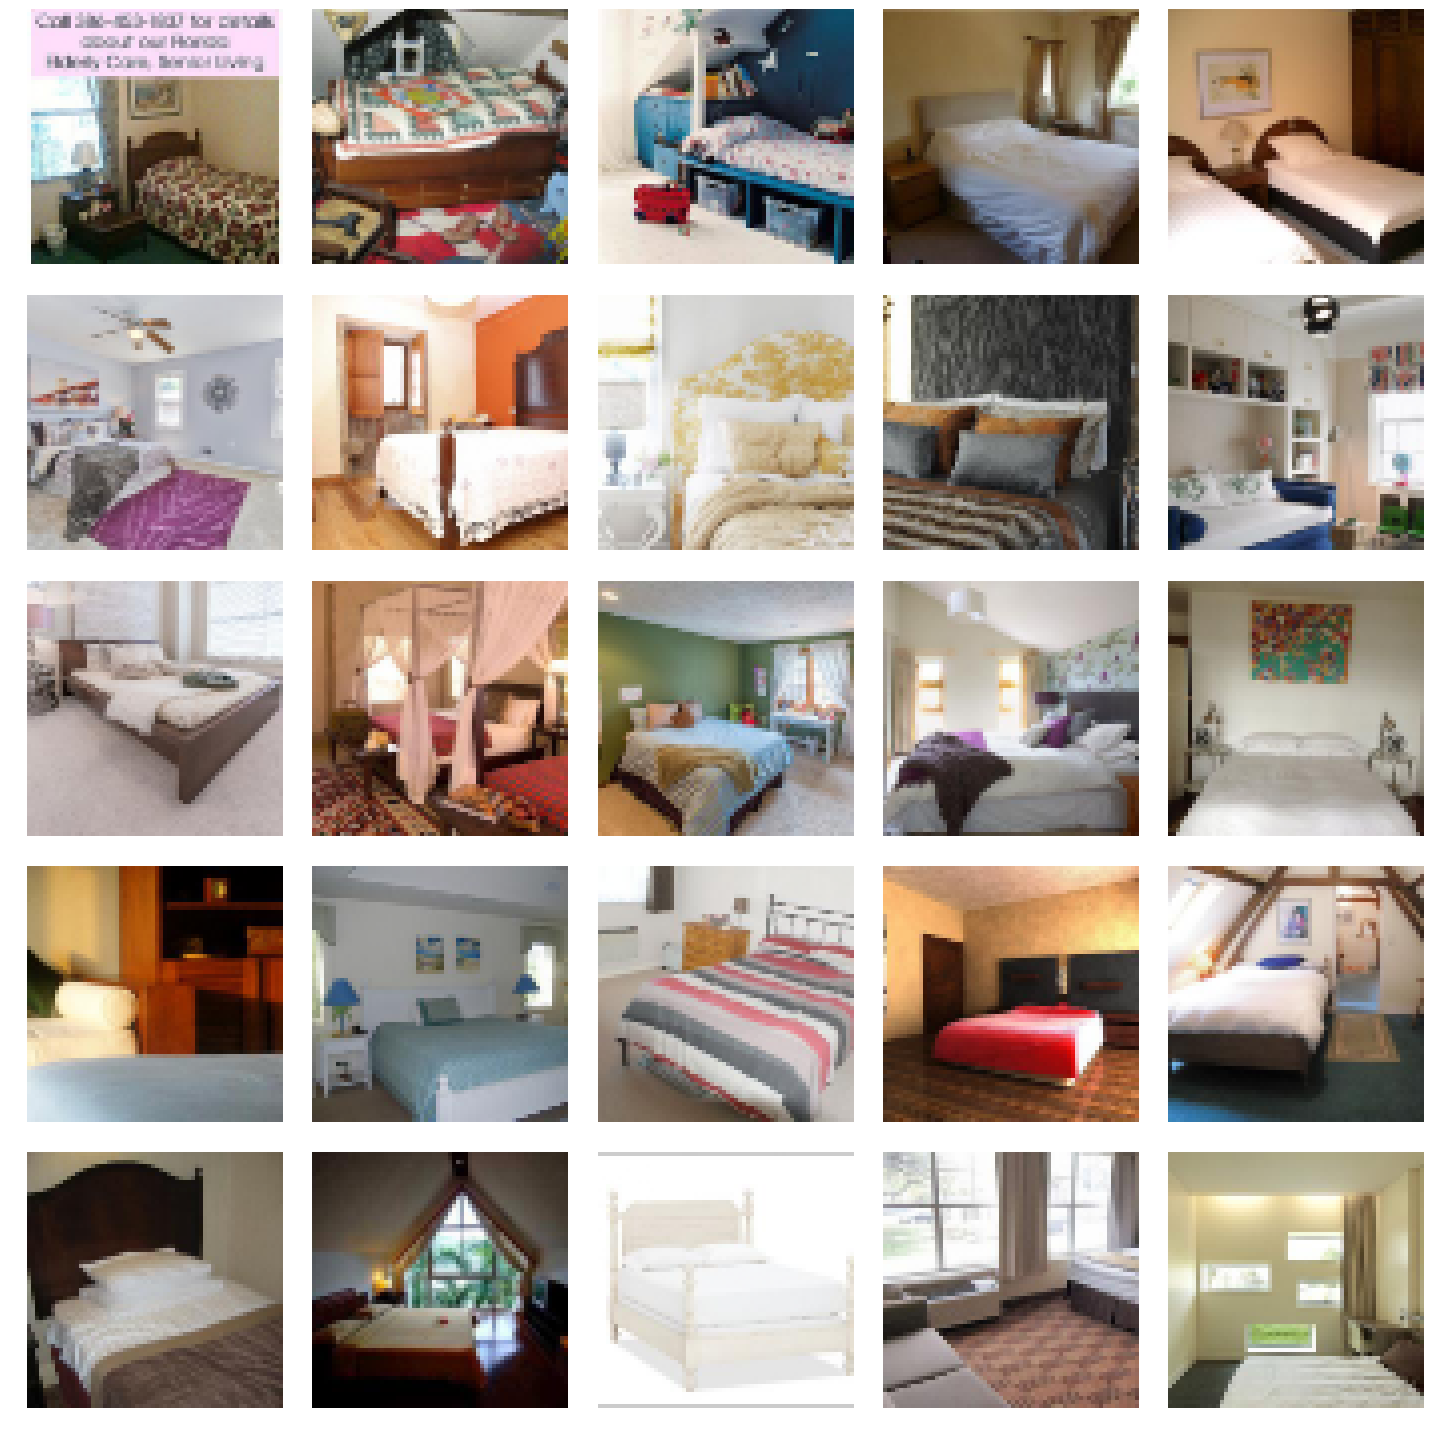

In [7]:
data.show_batch(rows=5)

## Models

Explain, at a high level, how a GAN works.

In [9]:
# GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) 
# and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: 
# a generator and a critic. The generator will try to make new images similar to the ones in our dataset, 
# and the critic will try to classify real images from the ones the generator does. The generator returns 
# images, the critic a single number (usually 0. for fake images and 1. for real ones).
# We train them against each other in the sense that at each step (more or less), we:
# 1. Freeze the generator and train the critic for one step by:
#   - getting one batch of true images (let's call that `real`)
#   - generating one batch of fake images (let's call that `fake`)
#   - have the critic evaluate each batch and compute a loss function from that; 
#     the important part is that it rewards positively the detection of real images and penalizes the fake ones
#   - update the weights of the critic with the gradients of this loss 
# 2. Freeze the critic and train the generator for one step by:
#   - generating one batch of fake images
#   - evaluate the critic on it
#   - return a loss that rewards posisitivly the critic thinking those are real images; 
#     the important part is that it rewards positively the detection of real images and penalizes the fake ones
#   - update the weights of the generator with the gradients of this loss
  
# Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

Create a `basic_generator` and a `basic_critic` to input into our `GANLearner`. `in_size=64`, `n_channels=3`, `n_extra_layers=1`. How is the size of the random vector used in the generator specified?

In [11]:
# The random vector is specified using noise_sz when the dataset was created.
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

Create a learner `learn` is a `GanLearner.wgan` that takes in `data`, `generator`, `critic`, chooses _not_ to `switch_eval` (why?), and, for an optimization function, uses `optim.Adam` with `betas=(0., 0.99)`. Set weight decay to `0.`.

In [12]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

Fit this for 30 epochs (or less if you don't have time) while with learning rate `2e-4`.

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.714019,#na#,0.514975,-0.958820,09:49


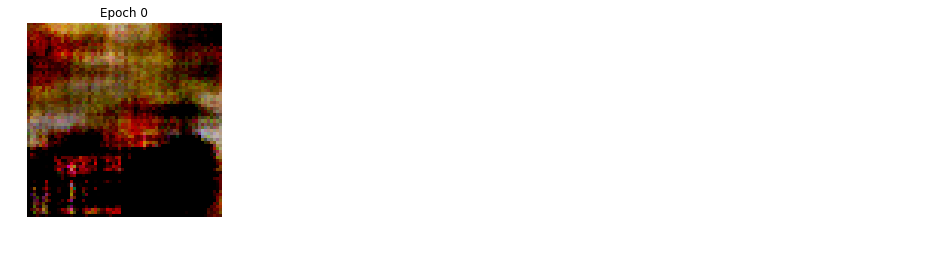

In [14]:
learn.fit(1,2e-4)

epoch,train_loss,gen_loss,disc_loss
1,-0.842719,0.542895,-1.086206
2,-0.799776,0.539448,-1.067940
3,-0.738768,0.538581,-1.015152
4,-0.718174,0.484403,-0.943485
5,-0.570070,0.428915,-0.777247
6,-0.545130,0.413026,-0.749381
7,-0.541453,0.389443,-0.719322
8,-0.469548,0.356602,-0.642670
9,-0.434924,0.329100,-0.598782
10,-0.416448,0.301526,-0.558442


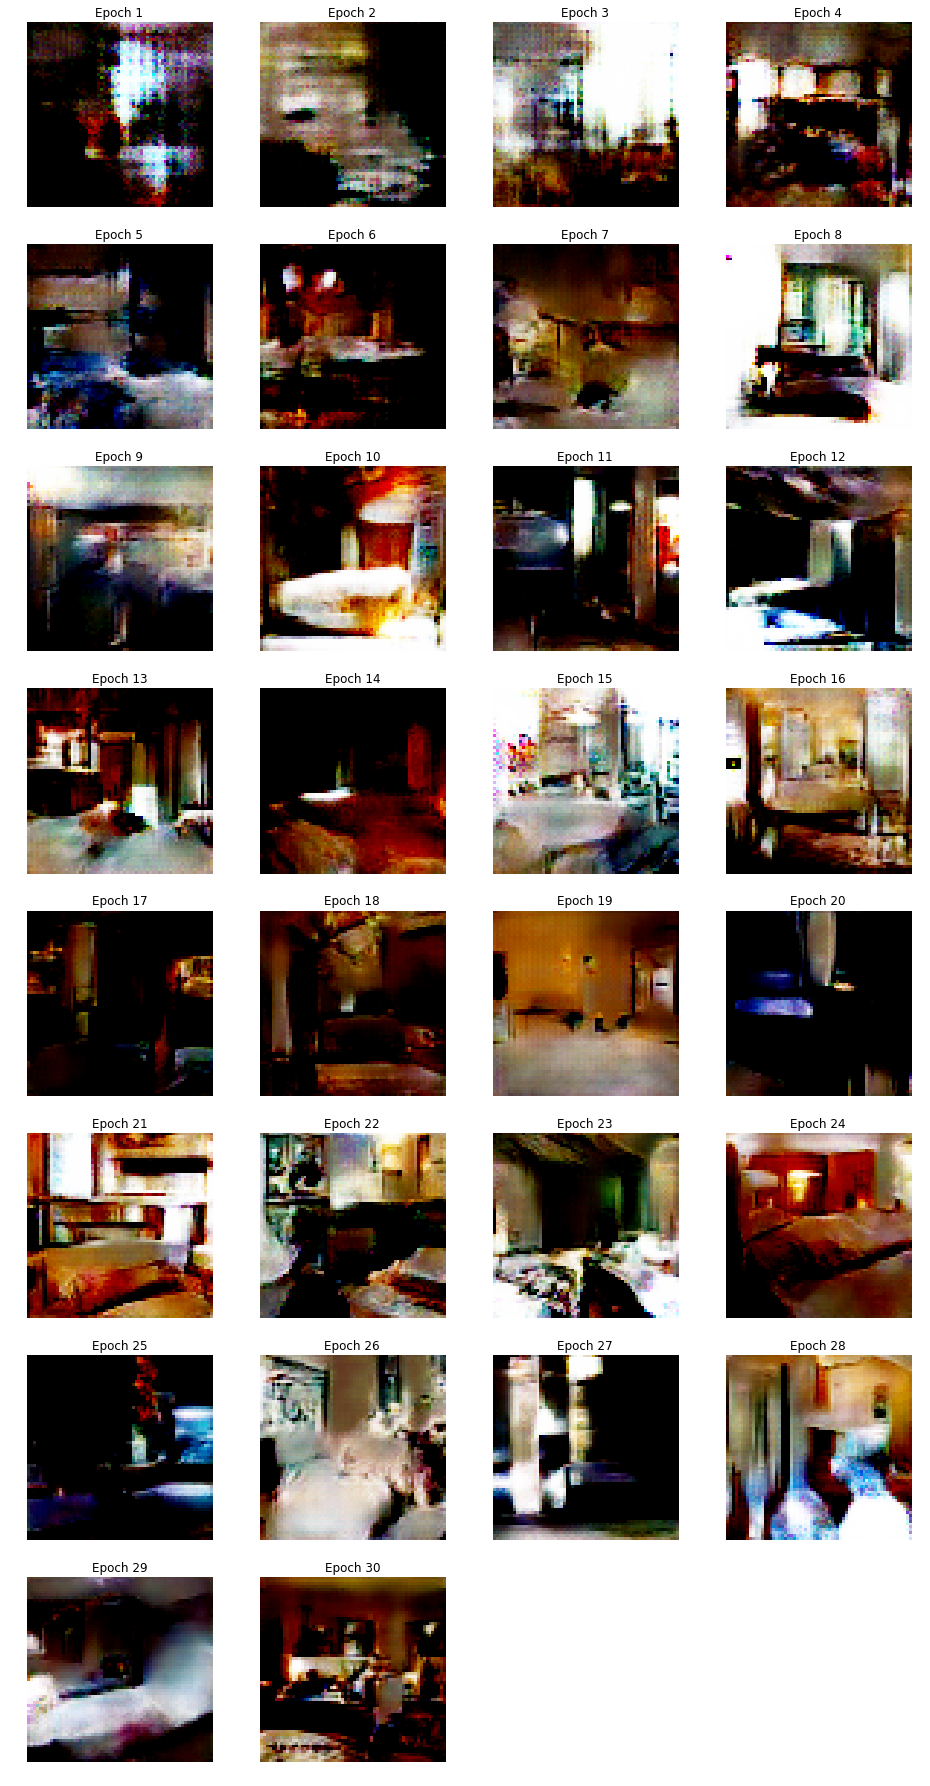

In [ ]:
learn.fit(30,2e-4)

Switch `gen_mode` on for `learn.gan_trainer`, and show 16 rows of 8x8 results from the training set.

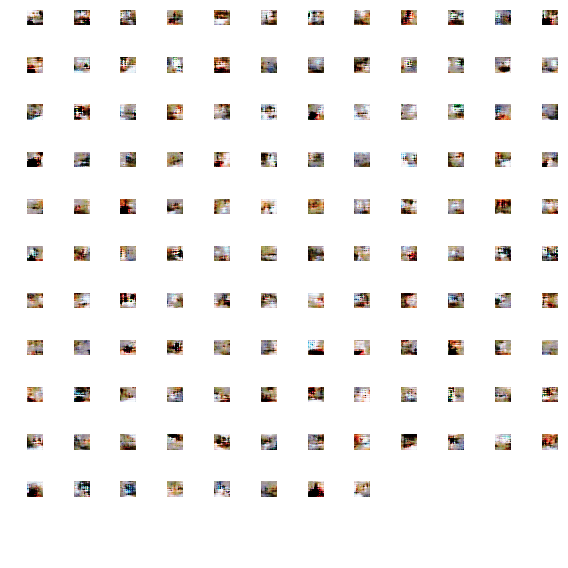

In [15]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16, figsize=(8,8))